---
title: 'Cohort Analysis for Ironhack Payments'
format: 
    html: 
        toc: true
        page-layout: full
        grid:
            body-width: 1600px
jupyter: python3
---

In [81]:
# To avoid confusion, we will disable warnings
import warnings
warnings.filterwarnings('ignore')

## Exploratory Data Analysis

> First, let's make sure we have the required modules

In [82]:
# uncomment the rows bellow to install the modules
# !pip install numpy
# !pip install pandas
# !pip install seaborn
# !pip install matplotlib

:::{.callout-tip}
When using environments, replace !pip with %pip
:::

> Now let's import the modules

In [83]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

> And now let's load the CSV files we'll be using

In [84]:
cash_df = pd.read_csv('project_dataset/extract - cash request - data analyst.csv')
fees_df = pd.read_csv('project_dataset/extract - fees - data analyst - .csv')

> Now we can start our exploratory analysis.

:::{.callout-note}
With `pandas` we can use [`.head()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.head.html) or [`.tail()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.tail.html), [`.info()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.info.html), [`.shape`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.shape.html) and [`.describe()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.describe.html) to get a quick view of the data.  
We can also use [`.sample(<number of samples>)`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sample.html) to see some randomly selected rows.
:::

In [85]:
cash_df.shape

(23970, 16)

In [86]:
cash_df.sample(5)

,id,amount,status,created_at,updated_at,user_id,moderated_at,deleted_account_id,reimbursement_date,cash_request_received_date,money_back_date,transfer_type,send_at,recovery_status,reco_creation,reco_last_update
21918,24766,25.0,money_back,2020-10-26 17:05:53.991896+00,2020-12-18 13:13:10.238231+00,72667.0,NaN,NaN,2020-11-12 22:00:00+00,2020-10-28,2020-11-02 19:10:19.925894+00,instant,2020-10-26 17:06:12.839122+00,NaN,NaN,NaN
9036,240,100.0,money_back,2019-12-19 09:43:06.192936+00,2020-11-04 12:55:43.903359+00,1416.0,2019-12-19 16:09:50.14958+00,NaN,2020-01-08 23:00:00+00,2019-12-22,NaN,regular,NaN,NaN,NaN,NaN
21905,26321,50.0,money_back,2020-10-30 10:57:50.370156+00,2020-12-18 13:13:08.949415+00,NaN,2020-10-30 12:58:06.763165+00,21682.0,2020-11-09 10:58:07.259046+00,2020-11-03,2020-11-12 23:00:00+00,instant,2020-10-30 10:58:07.259046+00,NaN,NaN,NaN
23663,22377,50.0,money_back,2020-10-20 08:42:18.890812+00,2020-12-18 13:15:52.241104+00,NaN,NaN,24529.0,2020-11-02 22:00:00+00,2020-10-20,2020-11-02 19:50:53.849447+00,instant,2020-10-20 08:42:31.651295+00,NaN,NaN,NaN
23858,15613,100.0,money_back,2020-09-10 20:47:02.466296+00,2020-12-18 13:16:41.657016+00,20550.0,2020-09-11 09:32:57.00028+00,NaN,2020-12-11 23:00:00+00,2020-09-12,2020-12-12 19:21:17.44995+00,instant,2020-09-17 20:47:02.421589+00,NaN,NaN,NaN


In [87]:
cash_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23970 entries, 0 to 23969
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          23970 non-null  int64  
 1   amount                      23970 non-null  float64
 2   status                      23970 non-null  object 
 3   created_at                  23970 non-null  object 
 4   updated_at                  23970 non-null  object 
 5   user_id                     21867 non-null  float64
 6   moderated_at                16035 non-null  object 
 7   deleted_account_id          2104 non-null   float64
 8   reimbursement_date          23970 non-null  object 
 9   cash_request_received_date  16289 non-null  object 
 10  money_back_date             16543 non-null  object 
 11  transfer_type               23970 non-null  object 
 12  send_at                     16641 non-null  object 
 13  recovery_status             333

In [88]:
fees_df.shape

(21061, 13)

In [89]:
fees_df.sample(5)

,id,cash_request_id,type,status,category,total_amount,reason,created_at,updated_at,paid_at,from_date,to_date,charge_moment
9103,20753,26673.0,instant_payment,accepted,NaN,5.0,Instant Payment Cash Request 26673,2020-10-31 14:57:52.795959+00,2020-10-31 14:57:52.795982+00,2020-12-01 19:33:24.699443+00,NaN,NaN,after
5034,15563,22809.0,instant_payment,accepted,NaN,5.0,Instant Payment Cash Request 22809,2020-10-21 13:37:03.031799+00,2020-10-21 13:37:03.031822+00,2020-11-09 19:22:07.850431+00,NaN,NaN,after
8298,11616,19635.0,instant_payment,accepted,NaN,5.0,Instant Payment Cash Request 19635,2020-10-07 11:25:08.181376+00,2020-10-13 14:25:00.943121+00,2020-11-05 20:12:12.31062+00,NaN,NaN,after
766,17053,24075.0,instant_payment,accepted,NaN,5.0,Instant Payment Cash Request 24075,2020-10-24 13:17:55.56988+00,2020-10-24 13:17:55.569904+00,2020-11-24 12:22:45.799481+00,NaN,NaN,after
8835,16880,20214.0,postpone,cancelled,NaN,5.0,Postpone Cash Request 20214,2020-10-24 08:03:22.479585+00,2020-10-24 08:03:22.47966+00,NaN,2020-10-24 19:40:44.576+00,2020-11-06 11:00:00+00,before


In [90]:
fees_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21061 entries, 0 to 21060
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               21061 non-null  int64  
 1   cash_request_id  21057 non-null  float64
 2   type             21061 non-null  object 
 3   status           21061 non-null  object 
 4   category         2196 non-null   object 
 5   total_amount     21061 non-null  float64
 6   reason           21061 non-null  object 
 7   created_at       21061 non-null  object 
 8   updated_at       21061 non-null  object 
 9   paid_at          15531 non-null  object 
 10  from_date        7766 non-null   object 
 11  to_date          7766 non-null   object 
 12  charge_moment    21061 non-null  object 
dtypes: float64(2), int64(1), object(10)
memory usage: 2.1+ MB


> We already notice that we have some columns with **numbers** (`amount` in `cash_df` and `total_amount` in `fees_df`), **datetime** (`created_at`, `updated_at` etc) and **object** (`status`, `transfer_type` etc).  
> Let's list the `unique()` values for latter.

In [91]:
print(f"status: {cash_df['status'].unique()}")
print(f"transfer_type: {cash_df['transfer_type'].unique()}")
print(f"recover_status: {cash_df['recovery_status'].unique()}")

status: ['rejected' 'money_back' 'canceled' 'active' 'direct_debit_rejected'
 'transaction_declined' 'direct_debit_sent']
transfer_type: ['regular' 'instant']
recover_status: [nan 'completed' 'pending' 'pending_direct_debit' 'cancelled']


:::{.callout-important}
Let's make a note that we have some `nan` (not-a-number) values - we'll get to that in a bit.
:::

In [92]:
print(f"type: {fees_df['type'].unique()}")
print(f"status: {fees_df['status'].unique()}")
print(f"category: {fees_df['category'].unique()}")
print(f"charge_moment: {fees_df['charge_moment'].unique()}")

type: ['instant_payment' 'incident' 'postpone']
status: ['rejected' 'accepted' 'cancelled' 'confirmed']
category: [nan 'rejected_direct_debit' 'month_delay_on_payment']
charge_moment: ['after' 'before']


## Data Quality Analysis Report

> Now that we've got an idea of the data, let's check if there are any missing (empty or `null`) values in our dataframes.  
> We can use [`.isna()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.isna.html) (or its alias - `isnull()`) and the inverse [`notna()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.notna.html#pandas.DataFrame.notna) to check if a value is **null**.

In [93]:
cash_df.isna().sum() # by appending .sum() we get a sum of Null values, per row

id                                0
amount                            0
status                            0
created_at                        0
updated_at                        0
user_id                        2103
moderated_at                   7935
deleted_account_id            21866
reimbursement_date                0
cash_request_received_date     7681
money_back_date                7427
transfer_type                     0
send_at                        7329
recovery_status               20640
reco_creation                 20640
reco_last_update              20640
dtype: int64

> We notice that the `user_id` column has 2103 `nan` values - but we also have a `deleted_account_id` column which contains id's for deleted user accounts.  
Let's check if there are rows where both `user_id` and `deleted_account_id` are empty.

In [94]:
(cash_df['user_id'].isna() & (cash_df['deleted_account_id'].isna())).sum()

0

> For the rest of the columns `nan` values are not necessarily a problem, so we won't investigate them further.  
> Now let's look at `fees_df`

In [95]:
fees_df.isna().sum()

id                     0
cash_request_id        4
type                   0
status                 0
category           18865
total_amount           0
reason                 0
created_at             0
updated_at             0
paid_at             5530
from_date          13295
to_date            13295
charge_moment          0
dtype: int64

> We notice there are 4 rows that don't have a value for `cash_request_id`

:::{.callout-tip}
The `isna()` function creates a **mask** with `True/False` where the values in the dataframe are `Null`. We can then use this **mask** to select rows from the dataframe
:::

In [96]:
fees_df[fees_df['cash_request_id'].isna()]

,id,cash_request_id,type,status,category,total_amount,reason,created_at,updated_at,paid_at,from_date,to_date,charge_moment
1911,2990,NaN,instant_payment,cancelled,NaN,5.0,Instant Payment Cash Request 11164,2020-08-06 22:42:34.525373+00,2020-11-04 16:01:17.296048+00,NaN,NaN,NaN,after
1960,3124,NaN,instant_payment,cancelled,NaN,5.0,Instant Payment Cash Request 11444,2020-08-08 06:33:06.244651+00,2020-11-04 16:01:08.332978+00,NaN,NaN,NaN,after
4605,5185,NaN,instant_payment,cancelled,NaN,5.0,Instant Payment Cash Request 11788,2020-08-26 09:39:37.362933+00,2020-11-04 16:01:36.492576+00,NaN,NaN,NaN,after
11870,3590,NaN,instant_payment,cancelled,NaN,5.0,Instant Payment Cash Request 12212,2020-08-12 14:20:06.657075+00,2020-11-04 16:01:53.106416+00,NaN,NaN,NaN,after


> As the `cash_request_id` is a reference to the `id` from the `cash_df` dataframe, and there are only 4 rows, we can safely remove/ignore these instances.

:::{.callout-tip}
We can use the inverse method `.notna()` and re-assign `fees_df` to the dataframe without `Null` values.
:::

In [97]:
fees_df = fees_df[fees_df['cash_request_id'].notna()]
fees_df.isna().sum()

id                     0
cash_request_id        0
type                   0
status                 0
category           18861
total_amount           0
reason                 0
created_at             0
updated_at             0
paid_at             5526
from_date          13291
to_date            13291
charge_moment          0
dtype: int64

## Metrics Analysis

> Before we can actually do our analysis, we need to prepare the dataframes for easier manipulation.  
> For this we'll convert the datetime values to the correct type.

In [98]:
datetime_columns_cash = ['created_at', 'updated_at', 'moderated_at', 'reimbursement_date',\
                          'cash_request_received_date', 'money_back_date', 'send_at',\
                         'reco_creation', 'reco_last_update']

for column in datetime_columns_cash:
    cash_df[column] = pd.to_datetime(cash_df[column]) # in python3.11.8 we need to add format='mixed'

In [99]:
cash_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23970 entries, 0 to 23969
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   id                          23970 non-null  int64              
 1   amount                      23970 non-null  float64            
 2   status                      23970 non-null  object             
 3   created_at                  23970 non-null  datetime64[ns, UTC]
 4   updated_at                  23970 non-null  datetime64[ns, UTC]
 5   user_id                     21867 non-null  float64            
 6   moderated_at                16035 non-null  datetime64[ns, UTC]
 7   deleted_account_id          2104 non-null   float64            
 8   reimbursement_date          23970 non-null  datetime64[ns, UTC]
 9   cash_request_received_date  16289 non-null  datetime64[ns]     
 10  money_back_date             16543 non-null  datetime64[ns,

In [100]:
datetime_columns_fees = ['created_at', 'updated_at', 'paid_at', 'from_date', 'to_date']
for column in datetime_columns_fees:
    fees_df[column] = pd.to_datetime(fees_df[column])

In [101]:
fees_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21057 entries, 0 to 21060
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype              
---  ------           --------------  -----              
 0   id               21057 non-null  int64              
 1   cash_request_id  21057 non-null  float64            
 2   type             21057 non-null  object             
 3   status           21057 non-null  object             
 4   category         2196 non-null   object             
 5   total_amount     21057 non-null  float64            
 6   reason           21057 non-null  object             
 7   created_at       21057 non-null  datetime64[ns, UTC]
 8   updated_at       21057 non-null  datetime64[ns, UTC]
 9   paid_at          15531 non-null  datetime64[ns, UTC]
 10  from_date        7766 non-null   datetime64[ns, UTC]
 11  to_date          7766 non-null   datetime64[ns, UTC]
 12  charge_moment    21057 non-null  object             
dtypes: datetime64[ns

> Now that our dataframes are cleaned and the values are of the correct type, we can start our analysis.

### 1. Frequency of Service Usage

**Understand how often users from each cohort utilize IronHack Payments' cash advance services over time.**

> To determine the utilisation of the IronHack Payments' service, we first need to group users in cohorts.  
> We will use the `created_at` field to generate the user cohorts, split by months.

In [143]:
cash_df['cohort'] = cash_df['created_at'].dt.to_period('M')

In [149]:
cohort_counts = cash_df.groupby('cohort').size()
cohort_counts

cohort
2019-11       1
2019-12     289
2020-01     223
2020-02     184
2020-03     244
2020-04     473
2020-05     837
2020-06    2615
2020-07    3601
2020-08    3417
2020-09    4221
2020-10    7725
2020-11     140
Freq: M, dtype: int64

> By analysing the cohort sizes, we can deduct that the data is incomplete for the first (2019-11) and last (2020-11) months - to avoid confusion we will hide these months from our plot.

In [150]:
cohort_counts = cohort_counts.iloc[1:-1]

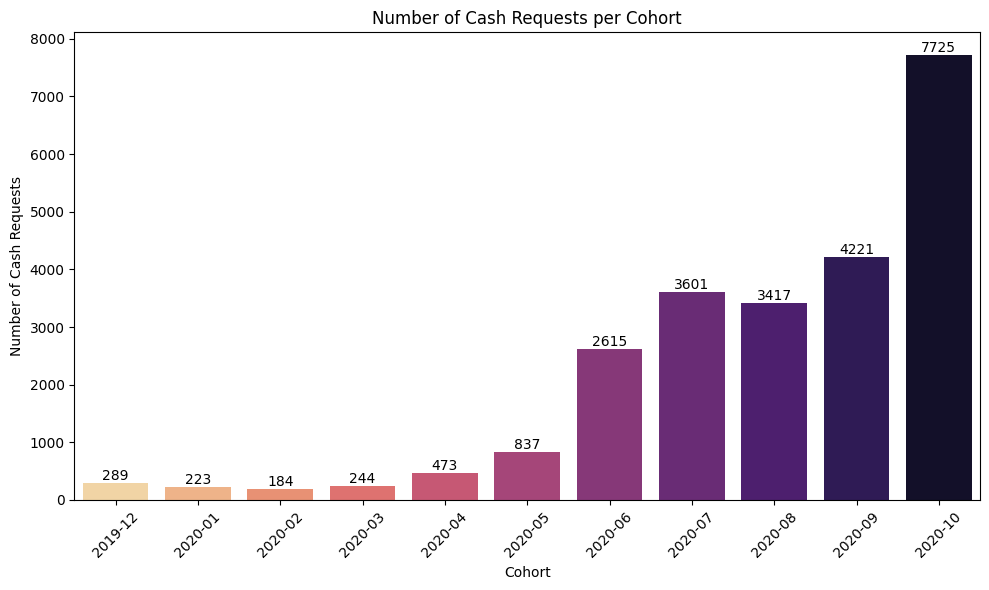

In [151]:
plt.figure(figsize=(10, 6))
freq_use = sns.barplot(x=cohort_counts.index.astype(str), y=cohort_counts.values, palette='magma_r')
plt.title('Number of Cash Requests per Cohort')
plt.xlabel('Cohort')
plt.ylabel('Number of Cash Requests')
plt.xticks(rotation=45)
plt.tight_layout()
# we can also show the values directly in the plot
for i in freq_use.containers:
    freq_use.bar_label(i,)

plt.show()

### 2. Incident Rate
**Determine the incident rate, specifically focusing on payment incidents, for each cohort. Identify if there are variations in incident rates among different cohorts.**

> To determine the **Incident Rate** we will look at the `fees_df` dataframe.  
> More specifically, we will consider an **incident** all the rows where `category` is *rejected_direct_debit* or *month_delay_on_payment*.  
> To actually determine the **rate** we need to calculate the percentage of *incidents* from all the fees payments.
>  
> First we will merge the two dataframes using the `id` from `cash_df` and `cash_request_id` from `fees_df` as indexes.
>  
> We will do a `inner` merge to assure that only the rows where there is a match between `id` and `cash_request_id` in both dataframes are included.

In [106]:
merged_df = pd.merge(cash_df, fees_df, left_on='id', right_on='cash_request_id', how='inner', suffixes=['_cash', '_fees'])
merged_df

,id_cash,amount,status_cash,created_at_cash,updated_at_cash,user_id,moderated_at,deleted_account_id,reimbursement_date,cash_request_received_date,...,status_fees,category,total_amount,reason,created_at_fees,updated_at_fees,paid_at,from_date,to_date,charge_moment
0,23534,25.0,money_back,2020-10-23 15:20:26.163927+00:00,2020-12-18 13:08:29.099365+00:00,21465.0,NaT,NaN,2020-11-10 23:51:00+00:00,NaT,...,accepted,NaN,5.0,Instant Payment Cash Request 23534,2020-10-23 15:21:35.895711+00:00,2020-10-23 15:21:35.895740+00:00,2020-11-06 07:16:22.014422+00:00,NaT,NaT,after
1,2203,100.0,money_back,2020-05-27 02:26:27.615190+00:00,2020-06-09 11:25:51.726360+00:00,2109.0,2020-05-27 10:02:13.094467+00:00,NaN,2020-07-15 02:26:27+00:00,2020-05-29,...,accepted,NaN,5.0,Postpone Cash Request 2203,2020-06-09 11:25:52.449808+00:00,2020-10-13 14:25:00.867548+00:00,NaT,2020-06-15 02:26:27+00:00,2020-07-15 02:26:27+00:00,before
2,6098,100.0,active,2020-07-01 09:30:03.145410+00:00,2020-08-11 22:27:58.240406+00:00,23328.0,2020-07-01 16:44:53.070844+00:00,NaN,2020-08-03 22:00:00+00:00,2020-07-03,...,cancelled,NaN,5.0,Postpone Cash Request 6098,2020-08-13 10:58:39.634220+00:00,2020-10-13 14:25:16.660127+00:00,NaT,2020-08-03 22:00:00+00:00,2020-09-03 10:58:32.274000+00:00,after
3,6098,100.0,active,2020-07-01 09:30:03.145410+00:00,2020-08-11 22:27:58.240406+00:00,23328.0,2020-07-01 16:44:53.070844+00:00,NaN,2020-08-03 22:00:00+00:00,2020-07-03,...,cancelled,NaN,5.0,Postpone Cash Request 6098,2020-08-13 10:58:52.603153+00:00,2020-10-13 14:25:16.661371+00:00,NaT,2020-08-03 22:00:00+00:00,2020-09-03 10:58:32.274000+00:00,after
4,6098,100.0,active,2020-07-01 09:30:03.145410+00:00,2020-08-11 22:27:58.240406+00:00,23328.0,2020-07-01 16:44:53.070844+00:00,NaN,2020-08-03 22:00:00+00:00,2020-07-03,...,cancelled,NaN,5.0,Postpone Cash Request 6098,2020-08-13 11:00:39.879521+00:00,2020-10-13 14:25:16.662449+00:00,NaT,2020-08-03 22:00:00+00:00,2020-09-01 11:00:34.027000+00:00,after
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21052,22357,100.0,money_back,2020-10-20 07:58:04.006937+00:00,2021-02-05 12:19:30.656816+00:00,82122.0,NaT,NaN,2021-02-05 11:00:00+00:00,2020-10-21,...,accepted,NaN,5.0,Instant Payment Cash Request 22357,2020-10-20 07:58:19.637461+00:00,2020-10-20 07:58:19.637491+00:00,2021-02-05 12:19:30.685779+00:00,NaT,NaT,after
21053,20256,100.0,money_back,2020-10-10 05:40:55.700422+00:00,2021-02-05 13:14:19.707627+00:00,64517.0,NaT,NaN,2021-02-05 11:00:00+00:00,2020-10-12,...,accepted,NaN,5.0,Postpone Cash Request 20256,2020-10-30 17:08:16.906449+00:00,2020-10-30 17:08:21.967966+00:00,2020-10-30 17:08:21.416796+00:00,2020-11-06 11:00:00+00:00,2020-12-07 11:00:00+00:00,before
21054,20256,100.0,money_back,2020-10-10 05:40:55.700422+00:00,2021-02-05 13:14:19.707627+00:00,64517.0,NaT,NaN,2021-02-05 11:00:00+00:00,2020-10-12,...,accepted,NaN,5.0,Instant Payment Cash Request 20256,2020-10-10 05:42:11.679401+00:00,2020-10-13 14:25:03.460352+00:00,2021-02-05 13:14:19.731397+00:00,NaT,NaT,after
21055,19886,100.0,direct_debit_sent,2020-10-08 14:16:52.155661+00:00,2021-01-05 15:45:52.645536+00:00,44867.0,NaT,NaN,2021-02-05 11:00:00+00:00,2020-10-10,...,accepted,NaN,5.0,Postpone Cash Request 19886,2020-10-10 21:22:00.083739+00:00,2020-10-13 14:25:18.501716+00:00,2020-10-10 21:22:04.456828+00:00,2020-11-06 22:00:00+00:00,2020-12-06 11:00:00+00:00,before


> We can now create a new dataframe with only the relevant columns: `user_id`, `type`, `category` and `cohort`

In [107]:
incidents_df = merged_df[['user_id', 'type', 'category', 'cohort']]
incidents_df.sample(10)

,user_id,type,category,cohort
13782,30491.0,instant_payment,NaN,2020-10
6278,13672.0,instant_payment,NaN,2020-08
6595,31751.0,instant_payment,NaN,2020-08
4210,2562.0,postpone,NaN,2020-06
1988,10562.0,instant_payment,NaN,2020-10
8763,80472.0,instant_payment,NaN,2020-10
18331,99916.0,instant_payment,NaN,2020-10
10639,778.0,instant_payment,NaN,2020-08
8692,36243.0,postpone,NaN,2020-08
17753,36760.0,instant_payment,NaN,2020-10


> We calculate the incident rate by:  
> - getting the count of all payments  
> - counting all the incidents - all the payments where `category` is not null.  
>  
> We group them by `cohort` to create a series so we can see the distribution per cohort.

In [108]:
total_payments = len(incidents_df)
incidents = incidents_df[incidents_df['category'].notna()].groupby('cohort').size()
incident_rate = (incidents / total_payments) * 100

> As `incidents` now contains a series, we need to convert it to a dataframe to plot it.

In [109]:
incident_rate_df = incident_rate.to_frame(name='Incident Rate per Cohort').reset_index()
incident_rate_df.columns = ['Cohort', 'Incident Rate (%)']
display(incident_rate_df)

,Cohort,Incident Rate (%)
0,2020-05,0.208957
1,2020-06,2.659448
2,2020-07,3.129601
3,2020-08,2.365009
4,2020-09,1.828371
5,2020-10,0.237451


:::{.callout-tip}
We will also export this dataframe to a csv file as we'll need it later.
:::

In [110]:
pd.DataFrame.to_csv(incident_rate_df, 'incidents.csv', index=False)

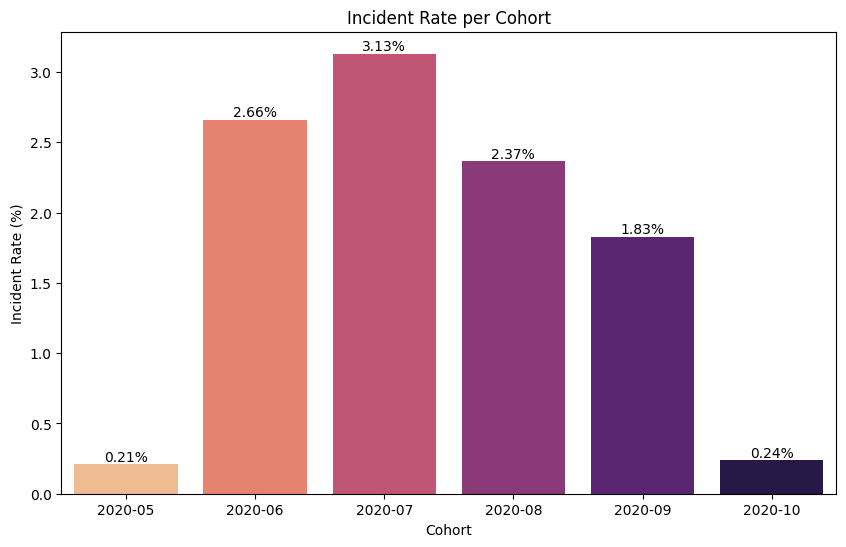

In [111]:
plt.figure(figsize=(10, 6))
incident_plot = sns.barplot(data=incident_rate_df, x='Cohort', y='Incident Rate (%)', palette='magma_r')
plt.title('Incident Rate per Cohort')
plt.ylabel('Incident Rate (%)')
plt.xlabel('Cohort')
incident_plot.bar_label(incident_plot.containers[0], fmt='%.2f%%')
plt.show()

### 3. Revenue Generated by the Cohort
**Calculate the total revenue generated by each cohort over months to assess the financial impact of user behavior.**

> To calculate the revenue generate per cohort we need to again look at both `cash_df` and `fees_df` dataframes.  
> We will use `merge_df` with the columns `user_id` and `cohort` from `cash_df` and `total_amount` from `fees_df`.  
> We'll also take the `paid_at` column from `fees_df` as we'll consider revenue only payments that have been actually paid - we'll ignore rows that don't have a value in the `paid_at` column.

In [112]:
revenue_df = merged_df[['user_id', 'cohort', 'total_amount', 'paid_at']]
revenue_df.sample(5)

,user_id,cohort,total_amount,paid_at
14773,87706.0,2020-10,5.0,2020-10-26 06:14:29.350912+00:00
17367,95760.0,2020-10,5.0,2020-11-04 19:57:33.546321+00:00
17774,96570.0,2020-10,5.0,2020-11-06 19:42:10.416658+00:00
399,8870.0,2020-05,5.0,NaT
9006,20820.0,2020-08,5.0,2020-09-17 01:17:06.976498+00:00


> Now we can filter out the rows that don't have a value for `paid_at`

In [113]:
revenue_df = revenue_df[revenue_df['paid_at'].notna()]

> And now we can calculate the revenue generated by each cohort.

In [114]:
cohort_revenue = revenue_df.groupby('cohort')['total_amount'].sum()
cohort_revenue

cohort
2020-05      290.0
2020-06     4155.0
2020-07     5430.0
2020-08    12445.0
2020-09    17715.0
2020-10    37065.0
2020-11      560.0
Freq: M, Name: total_amount, dtype: float64

In [115]:
# We save a csv for later use
pd.DataFrame.to_csv(revenue_df, 'revenue.csv', index=False)

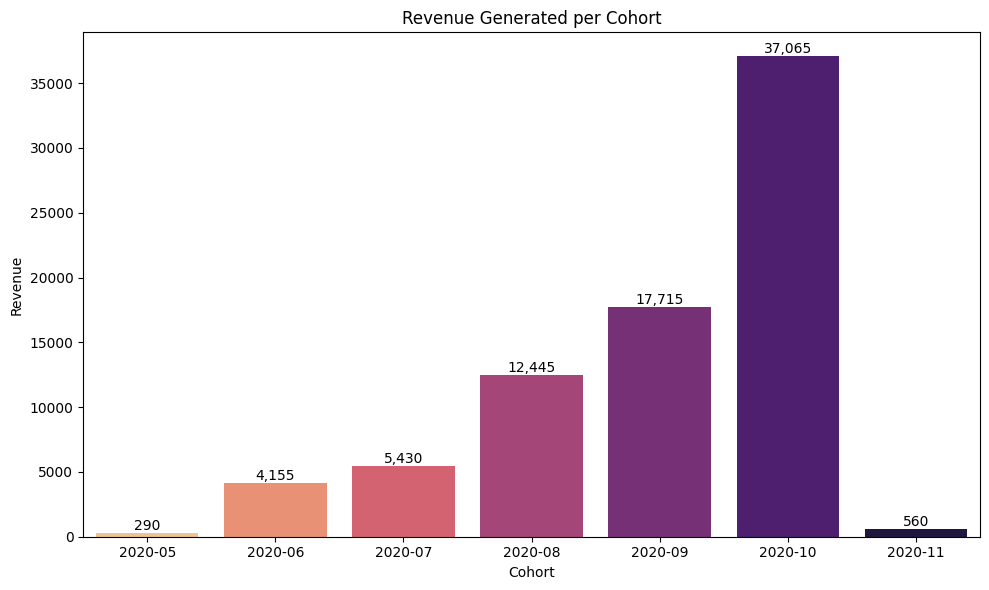

In [116]:
plt.figure(figsize=(10, 6))
revenue_plot = sns.barplot(x=cohort_revenue.index.astype(str), y=cohort_revenue.values, palette='magma_r')
plt.title('Revenue Generated per Cohort')
plt.xlabel('Cohort')
plt.ylabel('Revenue')
# plt.xticks(rotation=45)
plt.tight_layout()
revenue_plot.bar_label(revenue_plot.containers[0], fmt='{:,.0f}')
plt.show()

### 4. New Relevant Metric 
**Propose and calculate a new relevant metric that provides additional insights into user behavior or the performance of IronHack Payments' services.**

> Given the data we have there are a couple of relevant metrics we could investigate that would provide additional insights into user behaviour.  
> One such metric could be **churn rate** - the percentage of users who stop using the IronHack Payments.  
>
> To calculate the **churn_rate** we will use the `cash_df` dataframe and calculate the percentage of deleted user accounts per cohort.

In [117]:
deleted_accounts = cash_df.groupby('cohort')['deleted_account_id'].count()
deleted_df = deleted_accounts
deleted_df

cohort
2019-11      0
2019-12     60
2020-01     47
2020-02     27
2020-03     37
2020-04     55
2020-05    110
2020-06    364
2020-07    442
2020-08    327
2020-09    419
2020-10    213
2020-11      3
Freq: M, Name: deleted_account_id, dtype: int64

In [118]:
# we already have a dataframe with created account per cohort
churn_df = pd.merge(left=deleted_df, right=cohort_counts.reset_index(), left_on='cohort', right_on='cohort')
churn_df.columns = [['cohort', 'deleted_accounts', 'new_accounts']]

:::{.callout-tip}
To calculate the **churn rate** we use the formula:  
$$
{Churn Rate} = \frac{Number of Deleted Accounts}{Number of New Accounts + Number of Deleted Accounts} \times 100
$$
:::
 

In [119]:
# we define a function that calculates the churn rate for a row
def calculate_churn_rate(row):
    if row['new_accounts'] == 0:  # To avoid division by zero
        return 0
    else:
        return float(row['deleted_accounts'] / (row['new_accounts'] + row['deleted_accounts']) * 100)

# and we call `.apply` on the `churn_df`; this will return a series
churn_rates = churn_df.apply(calculate_churn_rate, axis=1)

# and we assign the series to a new column
churn_df['churn_rate'] = churn_rates

churn_df

,cohort,deleted_accounts,new_accounts,churn_rate
0,2019-12,60,289,17.191977
1,2020-01,47,223,17.407407
2,2020-02,27,184,12.796209
3,2020-03,37,244,13.167260
4,2020-04,55,473,10.416667
5,2020-05,110,837,11.615628
6,2020-06,364,2615,12.218865
7,2020-07,442,3601,10.932476
8,2020-08,327,3417,8.733974
9,2020-09,419,4221,9.030172


In [152]:
pd.DataFrame.to_csv(churn_df, 'churn.csv', index=False)

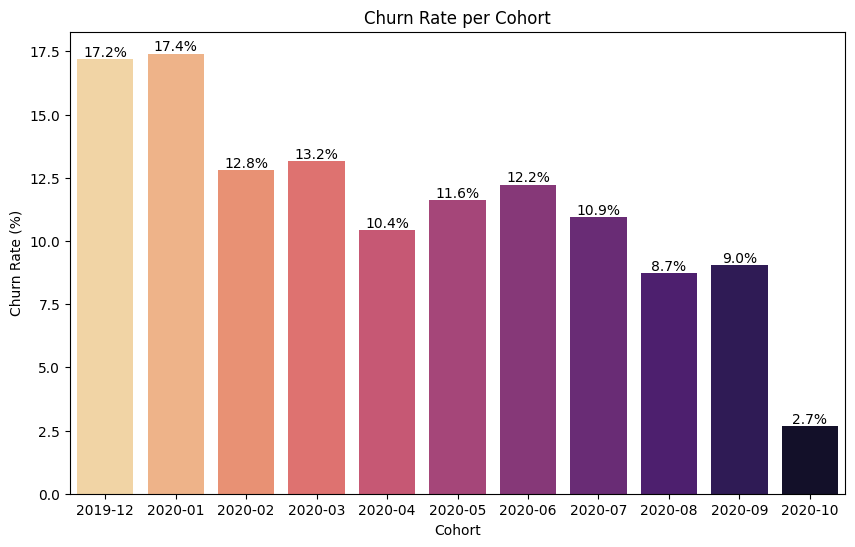

In [120]:
plt.figure(figsize=(10, 6))
churn_plot = sns.barplot(x=churn_df['cohort'].unstack(0), y=churn_rates.values, data=churn_df, palette='magma_r')
plt.title('Churn Rate per Cohort')
plt.xlabel('Cohort')
plt.ylabel('Churn Rate (%)')
# plt.xticks(rotation=45)
churn_plot.bar_label(churn_plot.containers[0], fmt='%.1f%%')
plt.show()

## Final considerations

The exported CSV files will be used for importing in Tableau to generate a dashboard.